In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-accidents/US_Accidents_Dec20_updated.csv
/kaggle/input/american-holidays/holidays.csv


<a id="intro"></a>
# Introduction
* We are Tom and Naor, 4th year students of Software and Information Systems Engineering at BGU (Ben-Gurion University)
* This project is part of our concluding task for Data Science course.
* We chose to focus on classifying the severity of an accident using ML tools and an innovative approach.
* Our main objective is to reach higher accuracy than majority rule classification. 

<a id="crispdm"></a>
# CrispDM
We will manage our project by following the Crisp DM steps.

# **Table of contents**
* [Introduction](#intro)
* [CrispDM](#crispdm)
> * [Business Understanding](#business-understanding)
> * [Data Understanding](#data-understanding)
> > **Data analysis**
> > * [Top 10 dangerous states](#top-10-dang-states)
> > * [Top 10 dangerous cities](#top-10-dang-cities)
> > * [Top 20 dangerous roads](#top-20-dang-roads)
> > * [Top 5 cities of top 5 dangerous states](#top-5-dang-st-city)


> * [Data Preparation](#data-preparation)
> > * [Data Selection](#data-selection)
> > > **Additional data analysis**
> > > * [Accidents distribution by years](#accidents-dist-years)
> > > * [Severity distribution](#severity-dist) 
> > > * [Amount of accidents per hour](#accidents-per-hour)
> > > * [Weather conditions on dangerous hours](#weather-conditions) 
> > > * [Road conditions on dangerous hours](#road-conditions)
> > > * [Correlation between features](#corr)
> > * [Data Cleaning](#data-cleaning)
> > > * [Missing values](#missing-values)
> > > * [Outlier detection and removal](#outliers)
> > > * [Noise elimination](#noise)

> > * [Data Transformation](#data-transformation)
> > > * [Feature Construction](#construction)
> > > * [Encoding](#encoding)
> > > * [Feature Aggregation](#aggregation)
> > > * [Generalization](#generalization)
> > > * [Normalization](#normalization)
> > * [Data Reduction](#data-reduction)


> * [Modeling](#modeling)
> > * [Models and Parameter Grids](#models-params)
> > * [Cross Validation Preparation](#cv)
> > * **Baseline - Severity Prediction**
> > > * [Train-Test Split](#train-test-split)
> > > * [Severity Prediction](#baseline-severity-prediction)
> > * **KMeans Based Data Split - Severity Prediction**
> > > * [KMeans Split](#kmeans-train-test-split)
> > > * [Severity Prediction](#kmeans-severity-prediction)
> * [Evaluation](#evaluation)


<a id="business-understanding"></a>
# Business Understanding
- Elaborated thoroughly in our report


<a id="data-understanding"></a>
# Data Understanding

In [2]:
!pip install pygeohash
# !pip install category_encoders

  Preparing metadata (setup.py) ... - done
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6168 sha256=b2523d5a2f39d0c799208a80549da1feac725f7baf6659b4733f2db25f552f94
  Stored in directory: /root/.cache/pip/wheels/e2/ed/86/be7141d743cfb4aebac76406187154cd78fe9e6535d872187a
Successfully built pygeohash


In [3]:
#IMPORTS

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#General
from collections import Counter
import gc
import math
import itertools
pd.options.mode.chained_assignment = None  # default='warn'

#Data Preparation
import pygeohash as pgh  
from sklearn import preprocessing
from category_encoders import target_encoder as te
from scipy.stats import ks_2samp

#Modeling
from sklearn.metrics import f1_score,make_scorer
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,IsolationForest
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression

In [4]:
accidents_df : pd.DataFrame = pd.read_csv('../input/us-accidents/US_Accidents_Dec20_updated.csv')
accidents_df.drop('ID',axis=1,inplace=True)

holidays_dates = pd.read_csv('../input/american-holidays/holidays.csv')
holidays_dates = set(pd.to_datetime(holidays_dates['Date']))

In [5]:
len(accidents_df)

1516064

In [6]:
accidents_df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,4.699690e+05,1.473031e+06,1.066748e+06,1.470555e+06,1.479790e+06,1.471853e+06,1.387202e+06,1.005515e+06
mean,2.238630e+00,3.690056e+01,-9.859919e+01,3.690061e+01,-9.859901e+01,5.872617e-01,8.907533e+03,5.958460e+01,5.510976e+01,6.465960e+01,2.955495e+01,9.131755e+00,7.630812e+00,8.477855e-03
std,6.081481e-01,5.165653e+00,1.849602e+01,5.165629e+00,1.849590e+01,1.632659e+00,2.242190e+04,1.827316e+01,2.112735e+01,2.325986e+01,1.016756e+00,2.889112e+00,5.637364e+00,1.293168e-01
min,1.000000e+00,2.457022e+01,-1.244976e+02,2.457011e+01,-1.244978e+02,0.000000e+00,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.385422e+01,-1.182076e+02,3.385420e+01,-1.182077e+02,0.000000e+00,1.212000e+03,4.700000e+01,4.080000e+01,4.800000e+01,2.944000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.735113e+01,-9.438100e+01,3.735134e+01,-9.437987e+01,1.780000e-01,4.000000e+03,6.100000e+01,5.700000e+01,6.800000e+01,2.988000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.072593e+01,-8.087469e+01,4.072593e+01,-8.087449e+01,5.940000e-01,1.010000e+04,7.300000e+01,7.100000e+01,8.400000e+01,3.004000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900058e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,1.551860e+02,9.999997e+06,1.706000e+02,1.130000e+02,1.000000e+02,5.804000e+01,1.400000e+02,9.840000e+02,2.400000e+01


In [7]:
accidents_df.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [8]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516064 entries, 0 to 1516063
Data columns (total 46 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Severity               1516064 non-null  int64  
 1   Start_Time             1516064 non-null  object 
 2   End_Time               1516064 non-null  object 
 3   Start_Lat              1516064 non-null  float64
 4   Start_Lng              1516064 non-null  float64
 5   End_Lat                1516064 non-null  float64
 6   End_Lng                1516064 non-null  float64
 7   Distance(mi)           1516064 non-null  float64
 8   Description            1516064 non-null  object 
 9   Number                 469969 non-null   float64
 10  Street                 1516064 non-null  object 
 11  Side                   1516064 non-null  object 
 12  City                   1515981 non-null  object 
 13  County                 1516064 non-null  object 
 14  State             

In [9]:
def get_value_counts(df,start,finish):
    return df.iloc[:,start:finish].apply(lambda col: col.value_counts() / len(col)*  100)

<a id=road-conditions-vc> </a> 

In [10]:
get_value_counts(accidents_df,29,42) #Road conditions

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
False,99.181895,99.982784,94.302153,99.785299,86.511255,99.885955,99.169956,99.996636,98.143416,98.832767,99.967745,88.788798,100.0
True,0.818105,0.017216,5.697847,0.214701,13.488745,0.114045,0.830044,0.003364,1.856584,1.167233,0.032255,11.211202,NaN


In [11]:
get_value_counts(accidents_df,43,48) #Visibility conditions 

,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
Day,63.920455,68.275680,71.959099
Night,36.074071,31.718846,28.035426


In [12]:
#Arbitrary params 
nAccident_prone_states = 10
nAccident_prone_cities_in_states = 5
nAccident_prone_cities = 10

<a id="top-10-dang-states"></a>
# Top 10 states with the most accidents

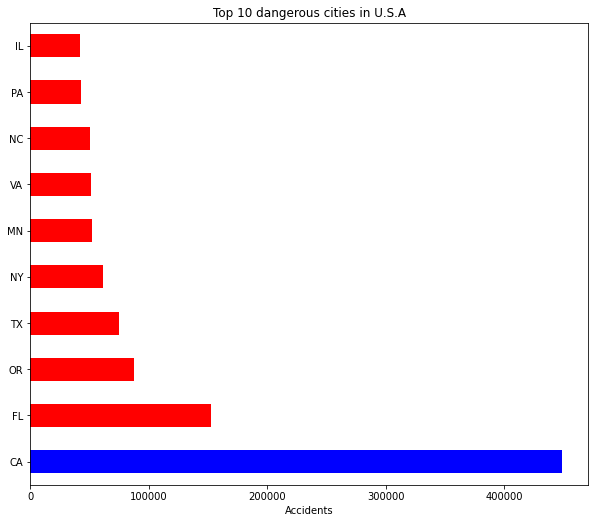

In [13]:
#Accident prone states
accident_prone_states_df = accidents_df['State'].value_counts()[:nAccident_prone_states]
accident_prone_states_df.plot(kind='barh',figsize=(10, 8.5),color=(["blue"]+["red"]*(nAccident_prone_states - 1)))
plt.title(f"Top {nAccident_prone_states} dangerous cities in U.S.A")
plt.xlabel("Accidents")
plt.show()

<a id="top-10-dang-cities"></a>
# Top 10 cities with the most accidents

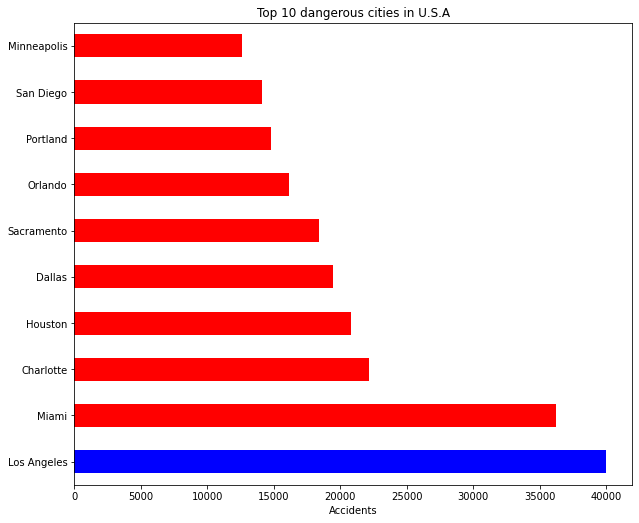

In [14]:
#Accident prone cities
accident_prone_cities_df = accidents_df['City'].value_counts()[:nAccident_prone_cities]
accident_prone_cities_df.plot.barh(figsize=(10, 8.5),color=(["blue"]+["red"]*(nAccident_prone_cities - 1)))
plt.title(f"Top {nAccident_prone_cities} dangerous cities in U.S.A")
plt.xlabel("Accidents")
plt.show()

<a id="top-20-dang-roads"></a>
# Top 20 dangerous roads

<AxesSubplot:>

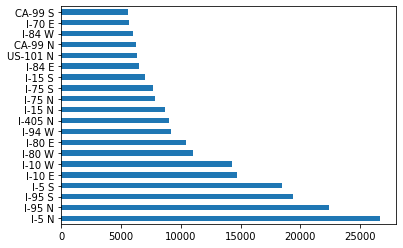

In [15]:
nAccidents_per_street = accidents_df['Street'].value_counts()
nAccidents_per_street.head(20).plot(kind='barh')

In [16]:
#percentage of number of streets with under ten accidents recorded
nAccidents_per_street = nAccidents_per_street.value_counts()
len(nAccidents_per_street.loc[nAccidents_per_street > 4]) / len(nAccidents_per_street) * 100 

25.82781456953642

<a id="top-5-dang-st-city"></a>
# Which cities in the most accident prone states have the most accidents?
- What is the overlap between accident prone cities in general and in accident prone states? 

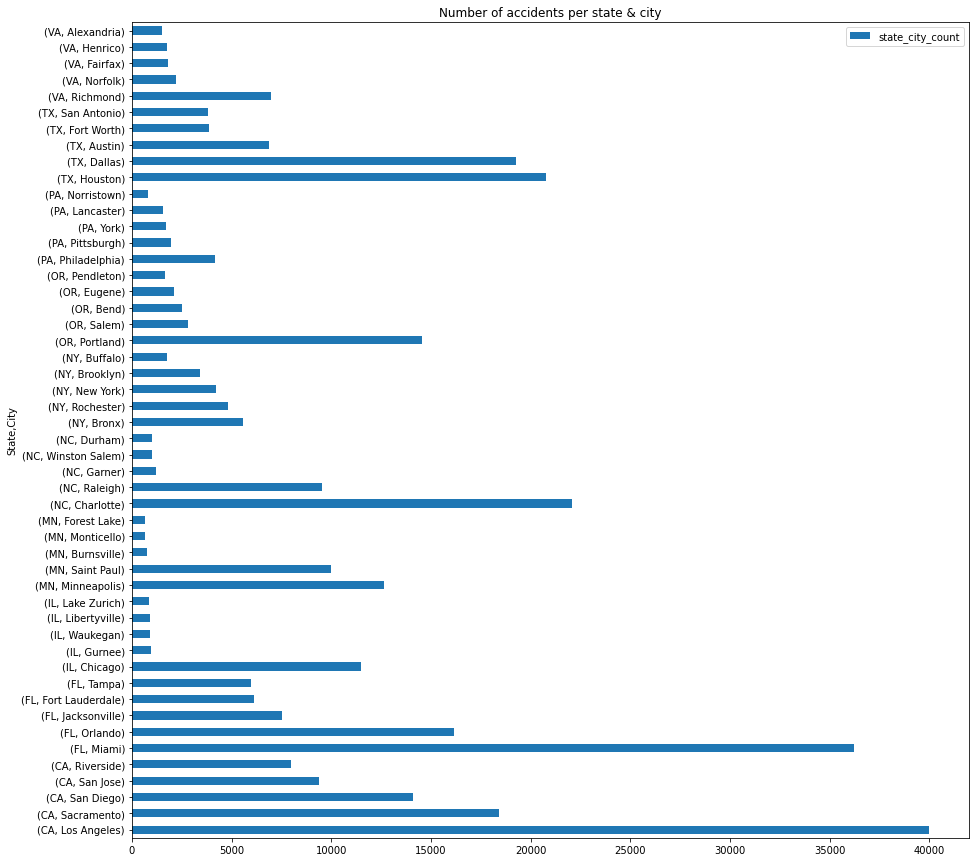

,City,state_city_count
State,,
CA,Los Angeles,39984
CA,Sacramento,18431
CA,San Diego,14090
CA,San Jose,9361
CA,Riverside,7963
FL,Miami,36199
FL,Orlando,16160
FL,Jacksonville,7542
FL,Fort Lauderdale,6103


In [17]:
#Accident prone cities in most accident prone states
accident_prone_states = accident_prone_states_df.index.to_list()
df_accident_prone_states = accidents_df[accidents_df['State'].isin(accident_prone_states)]
df_accident_prone_cities_in_states = df_accident_prone_states.groupby(['State','City'])['Severity'].count().rename('state_city_count')
df_accident_prone_cities_in_states = df_accident_prone_cities_in_states.reset_index().groupby(['State'],as_index=False).apply(lambda x: x.nlargest(nAccident_prone_cities_in_states,'state_city_count'))

df_accident_prone_cities_in_states.set_index(keys=['State', 'City']).plot.barh(color=("tab:blue"), figsize=(15, 15))
plt.title("Number of accidents per state & city")
plt.show()
df_accident_prone_cities_in_states = df_accident_prone_cities_in_states.set_index('State')
df_accident_prone_cities_in_states

In [18]:
# The most accident prone cities which also reside in the most accident prone states
accident_prone_cities = accident_prone_cities_df.index.to_list()
accident_prone_cities_in_states = df_accident_prone_cities_in_states['City'].to_list()
accident_prone_cities_in_both = set(accident_prone_cities).intersection(accident_prone_cities_in_states)
accident_prone_cities_in_both

{'Charlotte',
 'Dallas',
 'Houston',
 'Los Angeles',
 'Miami',
 'Minneapolis',
 'Orlando',
 'Portland',
 'Sacramento',
 'San Diego'}

In [19]:
# Out of the most accident prone states which also reside in the most accident prone states, what is the distribution over said states? 
overall_accident_prone_cities_df = df_accident_prone_cities_in_states[df_accident_prone_cities_in_states['City'].isin(accident_prone_cities_in_both)]
accident_prone_states_counter = Counter(overall_accident_prone_cities_df.index.to_list())
accident_prone_states_counter

Counter({'CA': 3, 'FL': 2, 'MN': 1, 'NC': 1, 'OR': 1, 'TX': 2})

# Missing Values analysis
focusing on most accident prone cities and on most accident prone states for further analysis

In [20]:
def get_missing_percentages(col):
    return 1 / len(col) * 100 * (col.isna().sum().sort_values(ascending=False))

In [21]:
#We choose to focus on states which have accident prone cities
accident_prone_states = [state for state,cities_count in accident_prone_states_counter.items() if cities_count > 1]
accident_prone_states

['CA', 'FL', 'TX']

In [22]:
#Overall missing values for comparison
total_missing_percentage = get_missing_percentages(accidents_df)
total_missing_percentage[total_missing_percentage > 0]

Number                   69.000715
Precipitation(in)        33.675953
Wind_Chill(F)            29.637007
Wind_Speed(mph)           8.499773
Humidity(%)               3.001786
Visibility(mi)            2.916170
Weather_Condition         2.902714
Temperature(F)            2.838469
Wind_Direction            2.760965
Pressure(in)              2.392643
Weather_Timestamp         1.996222
Airport_Code              0.280199
Timezone                  0.151841
Zipcode                   0.061673
Sunrise_Sunset            0.005475
Civil_Twilight            0.005475
Nautical_Twilight         0.005475
Astronomical_Twilight     0.005475
City                      0.005475
dtype: float64

In [23]:
accident_prone_cities_df = accidents_df[(accidents_df['City'].isin(accident_prone_cities_in_both)) & (accidents_df['State'].isin(accident_prone_states))]
missing_percentages = accident_prone_cities_df.groupby('State').apply(lambda col : get_missing_percentages(col))
missing_percentages = missing_percentages[ missing_percentages > 0]
missing_percentages

State                   
CA     Number               78.578029
       Precipitation(in)    35.953383
       Wind_Chill(F)        28.031170
       Wind_Speed(mph)       9.054548
       Wind_Direction        1.587477
       Humidity(%)           1.128198
       Temperature(F)        1.021998
       Pressure(in)          0.791670
       Visibility(mi)        0.766844
       Weather_Condition     0.733743
       Weather_Timestamp     0.622026
FL     Number               49.364961
       Wind_Chill(F)        27.515804
       Precipitation(in)    21.952291
       Wind_Speed(mph)       3.386237
       Humidity(%)           3.002349
       Temperature(F)        2.754063
       Visibility(mi)        1.550832
       Wind_Direction        1.124926
       Weather_Condition     1.103917
       Pressure(in)          0.639814
       Weather_Timestamp     0.590156
TX     Number               74.946974
       Wind_Chill(F)        46.245789
       Precipitation(in)    45.437305
       Wind_Speed(mph)   

State
CA    AxesSubplot(0.125,0.125;0.775x0.755)
FL    AxesSubplot(0.125,0.125;0.775x0.755)
TX    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Missing Percentage, dtype: object

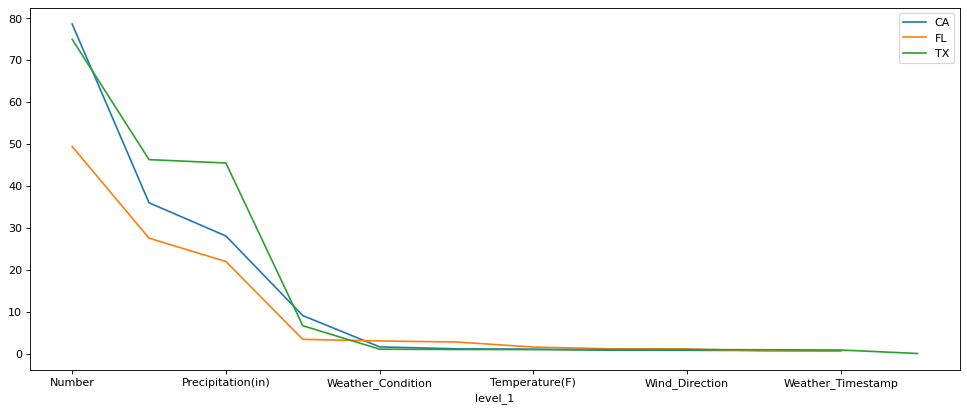

In [24]:
#Displaying meaningful missing values 
plt.figure(figsize=(15, 6), dpi=80)
missing_percentages = missing_percentages.reset_index().set_index('level_1').rename(columns={0: 'Missing Percentage'})
missing_percentages.index
missing_percentages.groupby('State')['Missing Percentage'].plot(legend=True)

# Duplications

In [25]:
accidents_df.duplicated().value_counts()

False    1405628
True      110436
dtype: int64

<a id="data-preparation"></a>
# Data Preparation

<a id="data-selection"></a>
# At this point, we choose to focus on the state of California
- California is an accident prone state. 
- California has 3 of the most accident prone cities overall.
- Most of the missing values in California's data are a part of 'Number' and 'Precipitation', which will be dealt with in the Data Preparation phase.

In [26]:
CA_accidents_df = accidents_df[accidents_df['State'] == 'CA']

<a id="accidents-dist-years"> </a>
# Assessing distribution of records over the years

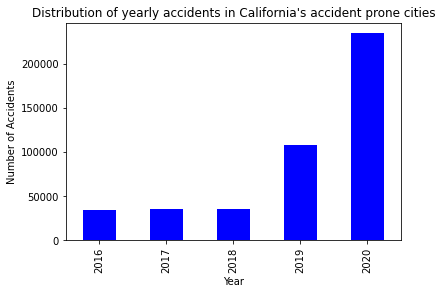

In [27]:
CA_accidents_df['Year'] = CA_accidents_df.Start_Time.str[:4]
years = CA_accidents_df.groupby('Year').size()
years.plot.bar(x='Year', y='Count', color="blue")
plt.title("Distribution of yearly accidents in California's accident prone cities")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
# plt.yscale('log')
plt.show()

In [28]:
nPrevalent_years = 2
prevalent_years = years.nlargest(nPrevalent_years).index.to_list()
percentage_accidents_prevalent_years = years.nlargest(2).sum() / years.sum() * 100
print(f'The {nPrevalent_years} most accident packed years are {prevalent_years}')
print(f'The {nPrevalent_years} most accident packed years make a total of {percentage_accidents_prevalent_years}% of accidents in California')

The 2 most accident packed years are ['2020', '2019']
The 2 most accident packed years make a total of 76.46407461126967% of accidents in California


### We sample the top 5 most accident prone cities in California.

In [29]:
#We narrow down our focus to most accident prone cities
nCities = len(CA_accidents_df['City'].unique()) #cities in California in the dataset 
CA_accident_prone_cities = df_accident_prone_cities_in_states[df_accident_prone_cities_in_states.index == 'CA']['City'].to_list()
CA_accidents_df = CA_accidents_df[CA_accidents_df['City'].isin(CA_accident_prone_cities)]

print(f'In this dataset, there are {nCities} cities in California')
print(f'We choose to focus on the top {nAccident_prone_cities_in_states} most accident prone, which are:\n\n {CA_accident_prone_cities}')

In this dataset, there are 1139 cities in California
We choose to focus on the top 5 most accident prone, which are:

 ['Los Angeles', 'Sacramento', 'San Diego', 'San Jose', 'Riverside']


# Severity distribution by percent 
<a id="severity-dist"></a>

In [30]:
def values_dist_by_percent(col):
    return col.value_counts() / len(col) * 100

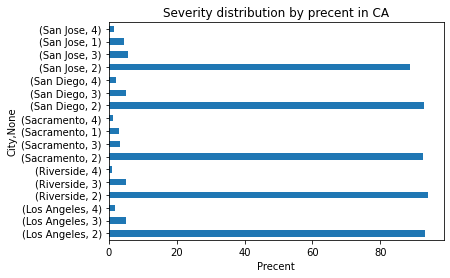

In [31]:
Severity_dist = CA_accidents_df.groupby('City')['Severity'].apply(values_dist_by_percent) 
Severity_dist.plot.barh()
plt.title('Severity distribution by precent in CA')
plt.xlabel('Precent')
plt.show()

In [32]:
san_jose = CA_accidents_df[CA_accidents_df['City'] == 'San Jose']
values_dist_by_percent(san_jose['Severity'])

2    88.601645
3     5.576327
1     4.358509
4     1.463519
Name: Severity, dtype: float64

# Accidents duration distribution in hours 
<a id="accidents-per-hour"></a>

In [33]:
#2. Accidents duration in hours in California State 
hourly_accidents_df = pd.DataFrame({})
hourly_accidents_df['Year'] = accidents_df.Start_Time.str[:4]
hourly_accidents_df['Start_Time'] = pd.to_datetime(CA_accidents_df['Start_Time'])
hourly_accidents_df['End_Time'] = pd.to_datetime(CA_accidents_df['End_Time'])
hourly_accidents_df['Accident_Duration_Hours'] = (hourly_accidents_df['End_Time'] - hourly_accidents_df['Start_Time']).apply(lambda x : x.seconds / 3600)
hourly_accidents_df = hourly_accidents_df.loc[hourly_accidents_df['Accident_Duration_Hours'] > 0,:]
hourly_accidents_df['Accident_Duration_Hours'].describe()

count    89829.000000
mean         2.660901
std          2.676879
min          0.100000
25%          0.583889
50%          1.493889
75%          6.000000
max         23.994444
Name: Accident_Duration_Hours, dtype: float64

### We attempt to focus on the most accident prone hours for further analysis.

In [34]:
nAccident_prone_hours = 5
nImpactful_weather_features = 10

In [35]:
min_bin = math.floor(hourly_accidents_df['Accident_Duration_Hours'].min())
max_bin = math.ceil(hourly_accidents_df['Accident_Duration_Hours'].max())
step = 0.5
hourly_bins = np.arange(start=min_bin,stop=max_bin + step,step=step)

hourly_accidents_df['Duration_Equal_Width_Bins'] = pd.cut(x=hourly_accidents_df['Accident_Duration_Hours'],bins=hourly_bins)
hourly_accidents_df['Duration_Equal_Width_Bins'].value_counts()[:nAccident_prone_hours] 

(0.5, 1.0]    23775
(5.5, 6.0]    19591
(1.0, 1.5]    10637
(0.0, 0.5]    10526
(1.5, 2.0]     8137
Name: Duration_Equal_Width_Bins, dtype: int64

# We notice that the number of accidents is in reverse ratio to the duration of the accident
- We choose to categorize the duration of accident to get a more convenient look at the distributions.
- We propose three categories: slow, medium and fast evacuation times for future analysis.
- We notice that there is an irregular number of accidents with 5.5 to 6 hours. 

In [36]:
#Trying to further understand the anomaly in hours lasting 5.5 to 6 hours. 
start = 6.0
end = 7.0
single_hour_distribution_df =  hourly_accidents_df[(hourly_accidents_df['Accident_Duration_Hours'] >= start) & (hourly_accidents_df['Accident_Duration_Hours'] < end)]
single_hour_distribution_df = single_hour_distribution_df.groupby(['Accident_Duration_Hours']).size().reset_index().rename(columns={0 : 'Duration_Record_Count'})
print(single_hour_distribution_df.head)

<bound method NDFrame.head of      Accident_Duration_Hours  Duration_Record_Count
0                   6.000000                  19243
1                   6.000278                      2
2                   6.000556                      4
3                   6.000833                      1
4                   6.001389                      1
..                       ...                    ...
464                 6.978889                      1
465                 6.983333                      3
466                 6.988889                      2
467                 6.991667                      3
468                 6.994444                      1

[469 rows x 2 columns]>


In [37]:
#Displaying how most values concentrate to excatly 6.0 hours.  
accidents_six_to_seven_hours = single_hour_distribution_df['Duration_Record_Count'][1:].sum()
single_hour_distribution_df.drop(single_hour_distribution_df[1:].index,inplace=True)
single_hour_distribution_df['Accident_Duration_Hours'] = single_hour_distribution_df['Accident_Duration_Hours'].apply(str)
single_hour_distribution_df.loc[1] = ['6 < x <= 7',accidents_six_to_seven_hours]
single_hour_distribution_df

,Accident_Duration_Hours,Duration_Record_Count
0,6.0,19243
1,6 < x <= 7,727


<a id="outliers-adh"></a>
<a id="noise"></a>
# We have found that there is an irregular amount of accidents lasting exactly 6 hours.  
- We have thoroughly read the data description and discussions over the dataset - this anomaly was not referred to.
- The data description refers to cases in which certain databases that data was gathered from were missing values for certain columns and were filled with default values, and we assume that the chance for this many accidents to have taken exactly 6 hours is miniscule.
- Therefore we believe the phenomena is due to default values, **and therefore choose to ignore all accidents lasting exactly 6 hours.** 

In [38]:
#We understand that 6 hours is an irregular value and therefore choose to ignore it. 
hourly_accidents_df = hourly_accidents_df.loc[hourly_accidents_df['Accident_Duration_Hours'] != 6.0]

In [39]:
#Since equal width bins are decreasing in size, we choose to discretize based on equal freq bins and determine levels of 
#evacuation speeds. 
hourly_accidents_df['Duration_Equal_Freq_Bins'],binning = pd.qcut(x=hourly_accidents_df['Accident_Duration_Hours'],q=3,labels=['Fast Evacuation', 'Moderate Evacuation ', 'Slow Evacuation'],retbins=True) 
binning

array([ 0.1       ,  0.61527778,  1.56194444, 23.99444444])

In [40]:
#Weather condition information - focusing on Weather Condition feature
num_conditions = len(CA_accidents_df["Weather_Condition"].unique())
impactful_weather_features = CA_accidents_df["Weather_Condition"].value_counts()[:nImpactful_weather_features]
prevalent_weather_percentage = impactful_weather_features.iloc[0] / impactful_weather_features.iloc[1:].sum() * 100

print(f'The number of weather conditions available in the dataset is {num_conditions}\n')
print(f'The top {nImpactful_weather_features} most impactful are:\n\n{impactful_weather_features}\n')
print(f'{impactful_weather_features.index.values[0]} weather accounts for {math.ceil(prevalent_weather_percentage)}% of accidents')

The number of weather conditions available in the dataset is 45

The top 10 most impactful are:

Fair                38469
Clear               13144
Mostly Cloudy        8559
Partly Cloudy        8048
Cloudy               7160
Light Rain           3139
Overcast             2904
Haze                 2646
Scattered Clouds     1774
Fog                  1010
Name: Weather_Condition, dtype: int64

Fair weather accounts for 80% of accidents


# Weather conditions across accident durations
<a id="weather-conditions"></a>

Duration_Equal_Freq_Bins
Fast Evacuation         AxesSubplot(0.125,0.125;0.775x0.755)
Moderate Evacuation     AxesSubplot(0.125,0.125;0.775x0.755)
Slow Evacuation         AxesSubplot(0.125,0.125;0.775x0.755)
Name: Weather Condition Count, dtype: object

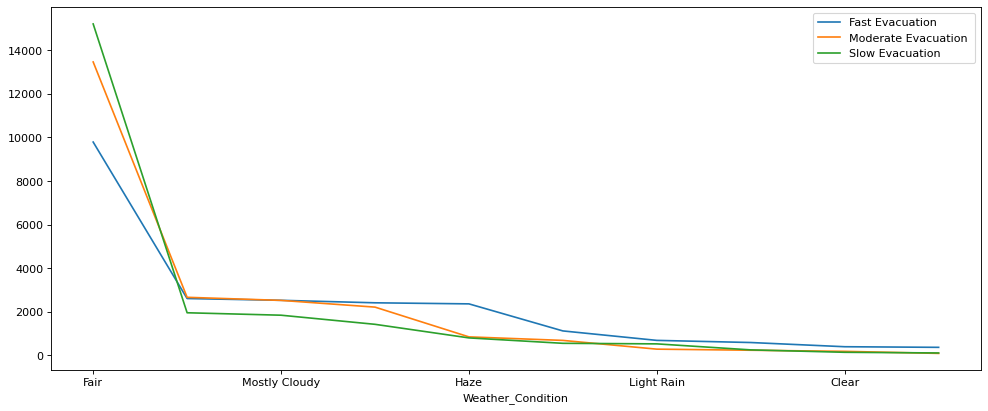

In [41]:
#showing connection between weather conditions and duration - choose busiest hours and show weather condition distribution graph. 
plt.figure(figsize=(15, 6), dpi=80)
CA_accidents_df['Duration_Equal_Freq_Bins'] = hourly_accidents_df['Duration_Equal_Freq_Bins']
weather_conditions = CA_accidents_df.groupby('Duration_Equal_Freq_Bins')["Weather_Condition"].value_counts()
weather_conditions = weather_conditions.groupby('Duration_Equal_Freq_Bins').apply(lambda x: x.nlargest(10))
weather_conditions = weather_conditions.droplevel(level=0).rename('Weather Condition Count').reset_index().set_index('Weather_Condition')

weather_conditions.groupby('Duration_Equal_Freq_Bins')['Weather Condition Count'].plot(legend=True)

<a id="road-conditions"> </a>
# Road conditions on dangerous hours
- Was based on [road conditions value distribution](#road-conditions-vc)

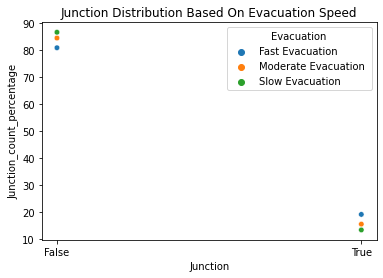

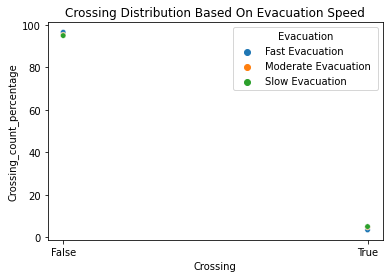

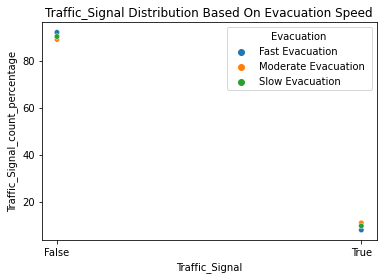

In [42]:
#showing connection between road condition and duration
road_conditions = ['Junction','Crossing','Traffic_Signal'] #with enough data to plot
for road_cond in road_conditions:
        road_conditions_df = pd.DataFrame({})
        road_conditions_df[road_cond] = CA_accidents_df.groupby('Duration_Equal_Freq_Bins')[road_cond].apply(lambda cond: cond.value_counts() / len(cond) * 100)
        road_conditions_df = road_conditions_df.reset_index().rename(columns={'Duration_Equal_Freq_Bins': 'Evacuation','level_1' : road_cond, road_cond : f'{road_cond}_count_percentage'})
        sns.scatterplot(x=road_cond, y=f'{road_cond}_count_percentage', hue='Evacuation', data=road_conditions_df,s=30)     
        plt.xticks([1.0, 0.0], ["True","False"])
        plt.title(f'{road_cond} Distribution Based On Evacuation Speed')
        plt.show()

<a id="corr"></a> 
# Checking for correlation between features

<AxesSubplot:>

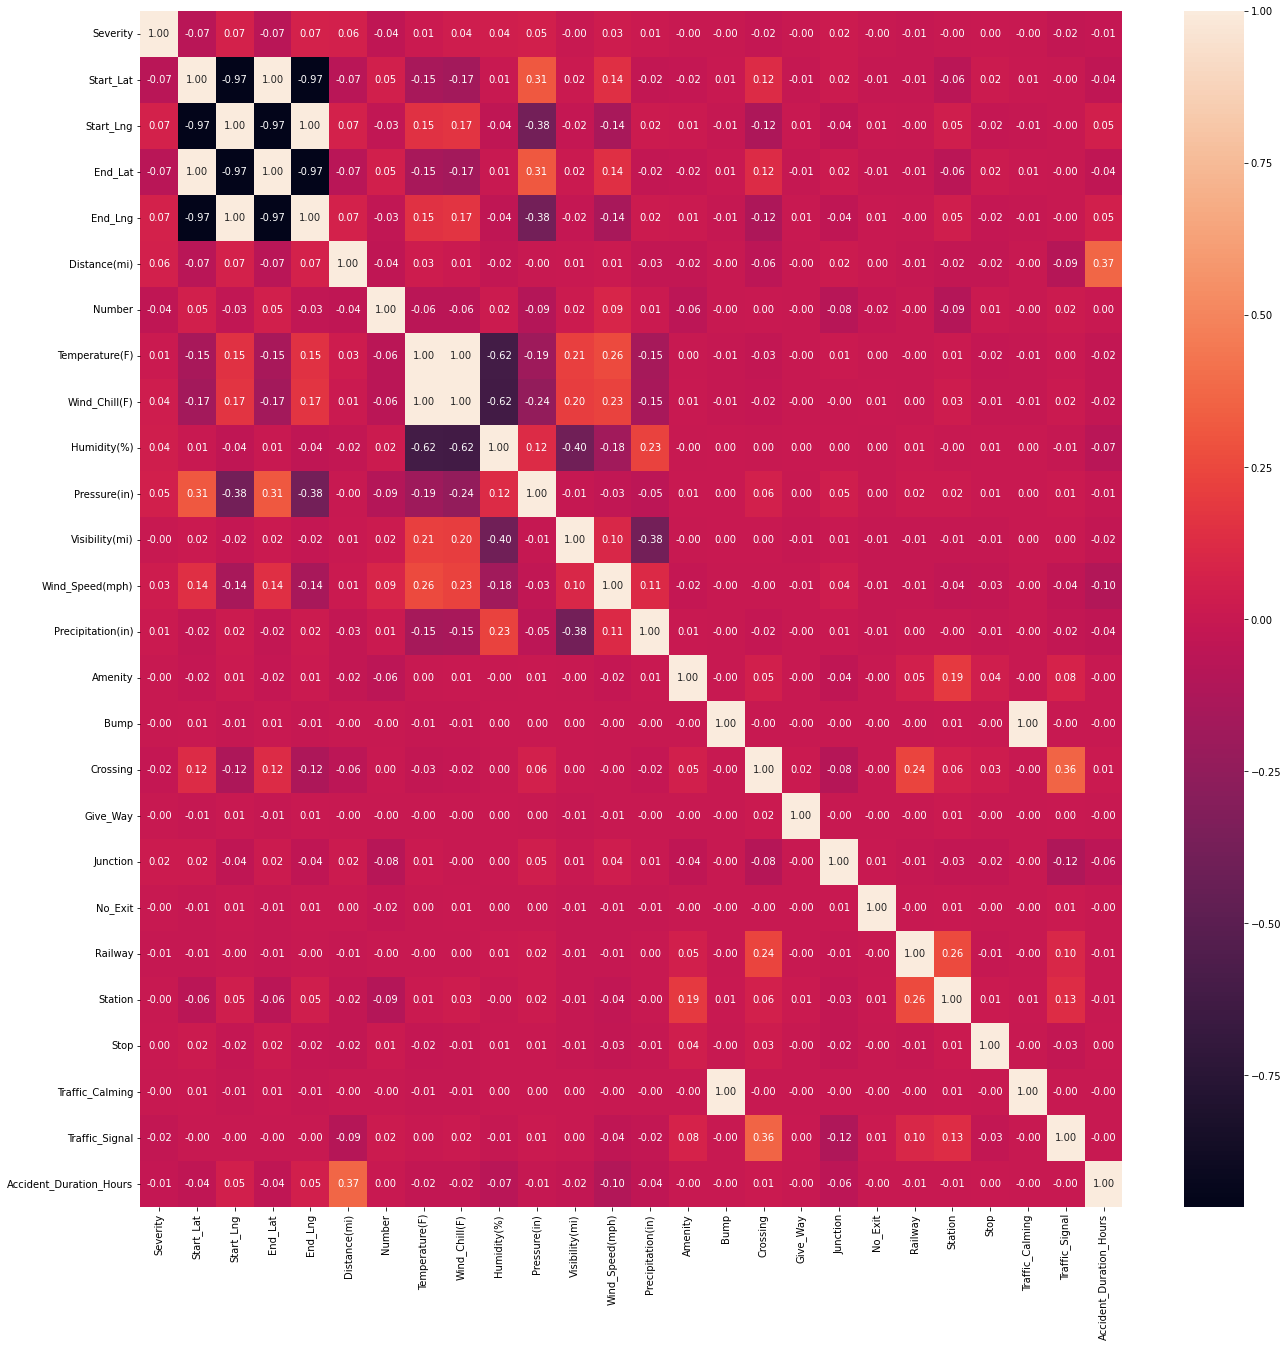

In [43]:
# check for correlation between features
CA_accidents_df.drop(['Duration_Equal_Freq_Bins','Roundabout','Turning_Loop'],axis=1,inplace=True) #meaningless axis
CA_accidents_df['Accident_Duration_Hours'] = hourly_accidents_df['Accident_Duration_Hours']
corr = CA_accidents_df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(22,22))
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,annot=True,ax=ax,fmt='.2f')

<a id="data-cleaning"></a>
# Data Cleaning
- Important to note the first step of removing noisy data was [removing accidents lasting exactly 6 hours](#outliers-adh)

<a id="missing-values"></a>

In [44]:
#finally narrowing down to a single city
accidents_df_sj = accidents_df[accidents_df['City'] == 'San Jose']

In [45]:
# Dropping rows with missing values
missing_percentages = get_missing_percentages(accidents_df_sj)

cols_to_drop = missing_percentages[missing_percentages > 1].index.to_list()
print(f'The columns dropped are: {cols_to_drop}')

accidents_df_sj = accidents_df_sj.drop(cols_to_drop, axis=1).dropna()
print(f'Current number of rows with null values: {accidents_df_sj.isna().sum().sum()}')

The columns dropped are: ['Number', 'Precipitation(in)', 'Wind_Chill(F)', 'Wind_Speed(mph)']
Current number of rows with null values: 0


<a id="outliers"></a>

In [46]:
# origin_len = len(accidents_df_sj)

# iso = IsolationForest(contamination=0.01) #default is 0.1 but too sensitive
# # lof = LocalOutlierFactor() #didn't impact results

# preds = iso.fit_predict(duration_col)

# accidents_df_sj = accidents_df_sj.loc[preds == 1].reset_index(drop=True)

# percent_accidents_removed = math.ceil(100 - (len(accidents_df_sj) / origin_len * 100))
# print(f'Up to {percent_accidents_removed}% of accidents were considered outliers and were removed')

<a id="data-construction"></a>
# Data Construction

<a id="construction"></a>
### Feature Construction

In [47]:
def get_season(day):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    # winter = everything else
    if day in spring:
        season = 'spring'
    elif day in summer:
        season = 'summer'
    elif day in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

In [48]:
accidents_df_sj['Start_Time'] = pd.to_datetime(accidents_df_sj['Start_Time'])
accidents_df_sj['Date'] = accidents_df_sj['Start_Time'].dt.date
accidents_df_sj['Year'] = accidents_df_sj['Start_Time'].dt.year
accidents_df_sj['Month'] = accidents_df_sj['Start_Time'].dt.month
accidents_df_sj['Hour'] = accidents_df_sj['Start_Time'].dt.hour 
accidents_df_sj['Day_of_Year'] = accidents_df_sj['Start_Time'].dt.dayofyear
accidents_df_sj['Season'] = accidents_df_sj['Day_of_Year'].apply(lambda x: get_season(x))
accidents_df_sj['Weekday'] = accidents_df_sj['Start_Time'].apply(lambda x: x.weekday())
accidents_df_sj['Is_Holiday'] = accidents_df_sj['Date'].apply(lambda x: x in holidays_dates) 

In [49]:
#Adding a feature to count the hours between the accident and when the weather was measured to approximate the relevance of weather conditions
accidents_df_sj['Weather_Timestamp'] = pd.to_datetime(accidents_df_sj['Weather_Timestamp'])
accidents_df_sj['Weather_Measurement_Proximity_Hours'] = (accidents_df_sj['Start_Time'] - accidents_df_sj['Weather_Timestamp']).apply(lambda x : x.seconds / 3600)
accidents_df_sj = accidents_df_sj.loc[accidents_df_sj['Weather_Measurement_Proximity_Hours'] > 0,:]
accidents_df_sj['Weather_Measurement_Proximity_Hours'].describe()

count    9211.000000
mean       12.510005
std        11.545917
min         0.000556
25%         0.266667
50%        20.713333
75%        23.729444
max        23.999722
Name: Weather_Measurement_Proximity_Hours, dtype: float64

In [50]:
def hours_to_peak(accident_hour):
    if 7 <= accident_hour < 9:
        return 'Morning_Peak'
    elif 17 <= accident_hour < 19:
        return 'Evening_Peak'
    else:
        return 'Not_Peak'
    
accidents_df_sj['Traffic_Peak_Status'] = accidents_df_sj['Hour'].apply(lambda h :hours_to_peak(h))
accidents_df_sj['Traffic_Peak_Status'].value_counts()

Not_Peak        6556
Evening_Peak    1665
Morning_Peak     990
Name: Traffic_Peak_Status, dtype: int64

In [51]:
accident_prone_hours = accidents_df_sj.groupby('Hour').size().nlargest(3).index.to_list()
accidents_df_sj['Are_Dangerous_Hours'] = accidents_df_sj['Hour'].apply(lambda h: h in accident_prone_hours)
accidents_df_sj['Are_Dangerous_Hours'].value_counts()

False    6746
True     2465
Name: Are_Dangerous_Hours, dtype: int64

In [52]:
accidents_df_sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9211 entries, 1021 to 1516016
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Severity                             9211 non-null   int64         
 1   Start_Time                           9211 non-null   datetime64[ns]
 2   End_Time                             9211 non-null   object        
 3   Start_Lat                            9211 non-null   float64       
 4   Start_Lng                            9211 non-null   float64       
 5   End_Lat                              9211 non-null   float64       
 6   End_Lng                              9211 non-null   float64       
 7   Distance(mi)                         9211 non-null   float64       
 8   Description                          9211 non-null   object        
 9   Street                               9211 non-null   object        
 10  Side  

In [53]:
#Instead of losing all information on many road conditions, we attempt to create a new feature out of all of them.  
road_conds_with_info = accidents_df_sj.iloc[:,25:38].apply(lambda col: col.value_counts() / len(col) * 100).dropna(axis=1).columns.to_list() 
accidents_df_sj['Has_Road_Conditions_Info'] = accidents_df_sj[road_conds_with_info].any(axis=1)
accidents_df_sj['Has_Road_Conditions_Info'].value_counts()

False    6079
True     3132
Name: Has_Road_Conditions_Info, dtype: int64

In [54]:
#Extract info from lng and ltd 
def create_geo_hash(start_series_name,end_series_name):
    return accidents_df_sj.apply(lambda x: pgh.encode(x[start_series_name], x[end_series_name], 5), axis=1)
    
accidents_df_sj['Geohash_Start'] = create_geo_hash('Start_Lat','Start_Lng')
accidents_df_sj['Geohash_End'] = create_geo_hash('End_Lat','End_Lng')

<a id="data-reduction"></a>
# Data Dimensionality Reduction
### Performed right after Data Construction since it was more convenient and efficient to focus only on the data required for further stages 
- Nearby road conditions with over 95% False values
- State, City, County, Country, Timezone,Lng and Lat aren't required since we focus on Los Angeles  
- Description refers mostly to street and required parsing, therefore it has limited value. 
- Accident Duration Hours will only be determined after the accident and so we can't use it. 
- Day of year and Date were mediatiors to get other features. 

In [55]:
#setting cols aside for later manipulations
start_time_col = accidents_df_sj['Start_Time']
date_col = accidents_df_sj['Date']

nearby_road_conditions = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Railway','Traffic_Calming', 'Turning_Loop']
geo_location = ['City', 'Timezone', 'County', 'State', 'Country','Start_Lng','Start_Lat','End_Lat','End_Lng']
redundant_after_data_prep = ['Day_of_Year','Date','Start_Time','End_Time']
other = ['Description','Weather_Timestamp']

accidents_df_sj.drop(nearby_road_conditions + geo_location +  redundant_after_data_prep + other, axis=1,inplace=True)

<a id="target-encoding"></a>

In [56]:
def target_encode(series_to_encode):
    return te.TargetEncoder().fit_transform(series_to_encode,accidents_df_sj['Severity'])

<a id="aggregation"></a>
# Feature Aggregation

In [57]:
# Adding aggregation functions based on recent time window
def agg_based_on_time_window(series,window_in_days=30,agg_funcs = ['sum','min','max','median','mean']):
    agg_funcs =  series.rolling(window=f'{window_in_days}D',min_periods=1).agg(agg_funcs)
    agg_funcs.columns =  map(str.capitalize, agg_funcs.columns)
    return agg_funcs

In [58]:
#for feature aggregation only
accidents_df_sj['Encoded_Zipcode'] = target_encode(accidents_df_sj['Zipcode'])
accidents_df_sj['Encoded_Street'] = target_encode(accidents_df_sj['Street'])

In [59]:
accidents_df_sj['cumcount_per_Street'] = accidents_df_sj.groupby('Encoded_Street').cumcount() + 1
accidents_df_sj['cumcount_per_Zipcode'] =accidents_df_sj.groupby('Encoded_Zipcode').cumcount() + 1
accidents_df_sj[['cumcount_per_Street','cumcount_per_Zipcode']] = accidents_df_sj[['cumcount_per_Street','cumcount_per_Zipcode']].astype('float64')

In [60]:
accidents_df_sj = accidents_df_sj.set_index(start_time_col).sort_index()

street_agg : pd.DataFrame = agg_based_on_time_window(accidents_df_sj['Encoded_Street']).add_prefix('Street_Monthly_')
zipcode_agg : pd.DataFrame = agg_based_on_time_window(accidents_df_sj['Encoded_Zipcode']).add_prefix('Zipcode_Monthly_')

accidents_df_sj = pd.concat([accidents_df_sj, street_agg,zipcode_agg], axis=1)

accidents_df_sj.reset_index(inplace=True,drop=True)

In [61]:
#cleanup
accidents_df_sj.drop(['Encoded_Zipcode','Encoded_Street'],axis=1,inplace=True)
del street_agg
del zipcode_agg
gc.collect()

42

<a id="generalization"></a>
# Generalization

In [62]:
#Uniting zipcodes through generalization
accidents_df_sj['Zipcode'] = accidents_df_sj['Zipcode'].astype(str).apply(lambda zipcode: zipcode[:5])

### Unifying low frequency categories to single category to extract information and narrow number of categories.

In [63]:
#turn multiple low freq categories to one category named 'other'
def unify_low_freq_categories(series,vc_series=None,cut_threshold=500):
    if vc_series is None:
        vc_series = series.value_counts()
    return series.mask(series.map(vc_series) < cut_threshold,'Other')  

<AxesSubplot:>

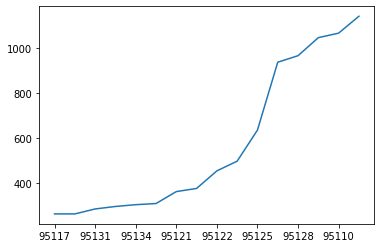

In [64]:
accidents_df_sj['Zipcode'] = unify_low_freq_categories(accidents_df_sj['Zipcode'],cut_threshold=200)
accidents_df_sj['Zipcode'].value_counts(ascending=True).plot()

<AxesSubplot:>

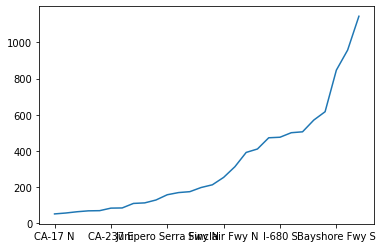

In [65]:
accidents_df_sj['Street'] = unify_low_freq_categories(accidents_df_sj['Street'],cut_threshold=50)
accidents_df_sj['Street'].value_counts(ascending=True).plot() #long tail, smaller cut threshold

In [66]:
accidents_df_sj['Geohash_Start'] = unify_low_freq_categories(accidents_df_sj['Geohash_Start'],cut_threshold=200)
accidents_df_sj['Geohash_End'] = unify_low_freq_categories(accidents_df_sj['Geohash_End'],cut_threshold=200)

#Dropping one of the Geohashes if they are similar (using Kolmogorov-Smirnov test) 
Kolmogorov_Smirnov_res = ks_2samp(accidents_df_sj['Geohash_Start'].values,accidents_df_sj['Geohash_End'].values)
if Kolmogorov_Smirnov_res.pvalue <= 0.05:
    accidents_df_sj.drop(['Geohash_End'],inplace=True,axis=1) 

In [67]:
accidents_df_sj['Weather_Condition'].value_counts(ascending=True)
accidents_df_sj['Weather_Condition'] = unify_low_freq_categories(accidents_df_sj['Weather_Condition'],cut_threshold=200)

<a id="encoding"></a>
# Encoding 
- [target encoding was defined here](#target-encoding)

In [68]:
categorical_cols = accidents_df_sj.select_dtypes(include=['object']).astype('category')
cat_cols_names = categorical_cols.columns.to_list()
for col in cat_cols_names:
    accidents_df_sj[col] = target_encode(categorical_cols[col])

In [69]:
day_night_to_bool = {'Day' : True, 'Night' : False}
accidents_df_sj[['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']] = accidents_df_sj[['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']].apply(lambda x: x.map(day_night_to_bool).astype('bool'))

bool_cols = accidents_df_sj.select_dtypes(include=['bool']).astype('category')
accidents_df_sj = accidents_df_sj.join(pd.get_dummies(bool_cols,dtype='float64'),rsuffix='_ohe')
accidents_df_sj.drop(bool_cols.columns.to_list(),axis=1,inplace=True)

In [70]:
accidents_df_sj.dtypes

Severity                                 int64
Distance(mi)                           float64
Street                                 float64
Side                                   float64
Zipcode                                float64
Airport_Code                           float64
Temperature(F)                         float64
Humidity(%)                            float64
Pressure(in)                           float64
Visibility(mi)                         float64
Wind_Direction                         float64
Weather_Condition                      float64
Year                                     int64
Month                                    int64
Hour                                     int64
Season                                 float64
Weekday                                  int64
Weather_Measurement_Proximity_Hours    float64
Traffic_Peak_Status                    float64
Geohash_Start                          float64
Geohash_End                            float64
cumcount_per_

<a id="normalization"></a>
# Normalization

In [71]:
#We observe min and max values to verify none of the other processes already normalized the values.
numeric_cols = [col for col in accidents_df_sj.columns.to_list() if not col.endswith(('_True','_False','Year'))]
numeric_cols.remove('Severity')
accidents_df_sj[numeric_cols].describe().loc[['min','max']].apply(lambda s: s.apply('{0:.2f}'.format))

,Distance(mi),Street,Side,Zipcode,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Street_Monthly_Sum,Street_Monthly_Min,Street_Monthly_Max,Street_Monthly_Median,Street_Monthly_Mean,Zipcode_Monthly_Sum,Zipcode_Monthly_Min,Zipcode_Monthly_Max,Zipcode_Monthly_Median,Zipcode_Monthly_Mean
min,0.00,1.95,2.04,2.00,2.03,28.00,10.00,19.91,0.06,1.92,...,2.00,1.28,2.00,2.00,1.96,2.01,1.28,2.01,2.01,2.01
max,5.07,2.19,2.06,2.08,2.05,107.60,100.00,30.55,10.00,2.31,...,1122.37,2.08,3.47,2.11,2.26,1128.43,2.07,3.47,2.07,2.11


In [72]:
#Actual normalization using sklearn - Preferred over Standardization because of different distributions.
def normalize(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled,dtype='float64')

accidents_df_sj[numeric_cols] = normalize(accidents_df_sj[numeric_cols])

In [73]:
accidents_df_sj.describe() #final validation before applying models

,Severity,Distance(mi),Street,Side,Zipcode,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Traffic_Signal_True,Sunrise_Sunset_True,Civil_Twilight_True,Nautical_Twilight_True,Astronomical_Twilight_True,Is_Holiday_False,Are_Dangerous_Hours_False,Are_Dangerous_Hours_True,Has_Road_Conditions_Info_False,Has_Road_Conditions_Info_True
count,9211.000000,9211.000000,9211.000000,9211.000000,9211.000000,9211.000000,9211.000000,9211.000000,9211.000000,9211.000000,...,9211.000000,9211.0,9211.0,9211.0,9211.0,9211.0,9211.000000,9211.000000,9211.000000,9211.000000
mean,2.041581,0.043888,0.394995,0.025404,0.542797,0.645385,0.421632,0.575190,0.945232,0.946576,...,0.046358,1.0,1.0,1.0,1.0,1.0,0.732385,0.267615,0.659972,0.340028
std,0.397204,0.064827,0.188608,0.157359,0.311673,0.478396,0.147044,0.228091,0.023214,0.156736,...,0.210270,0.0,0.0,0.0,0.0,0.0,0.442740,0.442740,0.473744,0.473744
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.258618,0.000000,0.286022,0.000000,0.315327,0.400000,0.936090,1.000000,...,0.000000,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.009082,0.404292,0.000000,0.654792,1.000000,0.403266,0.600000,0.945489,1.000000,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.000000,0.000000
75%,2.000000,0.074038,0.514023,0.000000,0.759434,1.000000,0.525126,0.755556,0.954887,1.000000,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
max,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000


In [74]:
accidents_df_sj.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9211 entries, 0 to 9210
Data columns (total 46 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Severity                             9211 non-null   int64  
 1   Distance(mi)                         9211 non-null   float64
 2   Street                               9211 non-null   float64
 3   Side                                 9211 non-null   float64
 4   Zipcode                              9211 non-null   float64
 5   Airport_Code                         9211 non-null   float64
 6   Temperature(F)                       9211 non-null   float64
 7   Humidity(%)                          9211 non-null   float64
 8   Pressure(in)                         9211 non-null   float64
 9   Visibility(mi)                       9211 non-null   float64
 10  Wind_Direction                       9211 non-null   float64
 11  Weather_Condition             

<a id="modeling"></a>
<a id="models-params"></a>
# Modeling

In [75]:
classifier_models = {
    LogisticRegression: {
        'solver': ['liblinear']
    },
    RandomForestClassifier: {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [4, 6, 8],
        'criterion': ['gini', 'entropy']
    },
    AdaBoostClassifier : {
        'n_estimators': [10, 50, 100, 500],
        'learning_rate': [0.001, 0.01, 0.1]
    },
#     SVC: {
#         'C': [0.1,1,100],
#         'gamma': [1,0.1,0.001],
#         'kernel': ['rbf', 'poly', 'sigmoid']
#     } 
}

In [76]:
score_name = 'accuracy'
rounding_decimals = 5

In [77]:
def get_score(X_train,y_train,X_test,y_test,model_class,params,cv=None):
    print(f'Current model being evaluated: {model_class.__name__}')
    scoring_metric = make_scorer(f1_score, average='weighted') if score_name == 'f1' else 'accuracy'
    if cv is not None:
        gscv = GridSearchCV(estimator=model_class(), param_grid=params,cv=cv, n_jobs=4, verbose=1,scoring=scoring_metric)
        gscv.fit(X_train, y_train)
        print('Best accuracy over training set: %s' % round(gscv.best_score_,5))
        params = gscv.best_params_
        m = model_class(**gscv.best_params_)
        del gscv
        gc.collect()
    else:
        m = model_class(**params)
        
    m.fit(X_train,y_train)
    if score_name == 'f1':
        score = f1_score(X_test,y_test,average=None)
    else:
        score = m.score(X_test,y_test)
    print(f'Accuracy score over test set is: {round(score,5)}')
    print('-----------------------------------------------------------\n')
    
    return score,m

<a id="cv"></a>

In [78]:
def get_cv(X_train,n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits) #originally 5 
    return list(tscv.split(X_train.index.values))   

In [79]:
def extract_importances(feat_importance,index_cols):
    importances = pd.Series(feat_importance, index=index_cols)
    importances = importances[importances > 0].nlargest(20).sort_values(ascending=True)
    importances.plot(kind='barh',figsize=(15,15))

In [80]:
yearly_idx_groups = accidents_df_sj.groupby('Year')
print(yearly_idx_groups.size())
print(accidents_df_sj[accidents_df_sj['Year'] == 2020].groupby('Month')['Severity'].apply(lambda month : month.value_counts() / len(month) * 100))

Year
2016    1105
2017    1058
2018    1112
2019    2429
2020    3507
dtype: int64
Month      
0.000000  2     99.577167
          4      0.422833
0.090909  2     99.026764
          4      0.486618
          3      0.486618
0.181818  2     81.670061
          1     16.700611
          3      1.425662
          4      0.203666
0.272727  2     45.989305
          1     44.919786
          3      6.951872
          4      2.139037
0.363636  2     63.517915
          1     28.990228
          3      6.514658
          4      0.977199
0.454545  2     67.964072
          1     20.059880
          3      8.083832
          4      3.892216
0.545455  2    100.000000
0.727273  2     94.871795
          4      5.128205
0.818182  2     97.894737
          4      2.105263
0.909091  2    100.000000
1.000000  2    100.000000
Name: Severity, dtype: float64


In [81]:
accidents_df_sj.drop('Year',axis=1,inplace=True)
accidents_df_sj['Date'] = date_col

<a id="train-test-split"></a>

In [82]:
#TRAIN-TEST TIME SPLIT
train_idx = [idx_list for (year,idx_list) in sorted(yearly_idx_groups.groups.items())] 

train_2020_idx = train_idx[-1]

train_idx[-1] = train_2020_idx[:len(train_2020_idx) // 2]
test_idx = train_2020_idx[len(train_2020_idx) // 2:]

train_idx = list(itertools.chain.from_iterable(train_idx))

X_train = accidents_df_sj.iloc[train_idx,:]
y_train = X_train.pop('Severity')
X_test = accidents_df_sj.iloc[test_idx,:]
y_test = X_test.pop('Severity')

train_dates = X_train.pop('Date')
test_dates = X_test.pop('Date')
cols = X_train.columns
                    
print(len(X_train))
print(len(X_test))     

7457
1754


In [83]:
def get_majority_rule(y_test):    
    if score_name == 'f1':
        m_rule = f1_score(pd.Series([2] * len(y_test)),y_test,average=None)
    else:
        m_rule = y_test.value_counts()[2] / len(y_test) # %records with severity 2
    
    print(f'Following majority rule for classification, we get {round(m_rule,rounding_decimals)} {score_name} rate.\n')
    return round(m_rule,rounding_decimals)

<a id="baseline-severity-prediction"></a>

In [84]:
majority_rule = get_majority_rule(y_test)

highest_score = 0
cv = get_cv(X_train,5)
for model,params in classifier_models.items():
    score,trained_model = get_score(X_train,y_train,X_test,y_test,model,params,cv)
    if score > highest_score:
        highest_score = score
    best_model = trained_model
        
print(f'The best model is {type(best_model).__name__} with {round(highest_score,rounding_decimals)}% accuracy rate\n')
original_improvement = (highest_score-majority_rule)*100
if original_improvement > 0:
    print(f'\nIn comparison to majority rule, this led to an improvement of {original_improvement}%') 

Following majority rule for classification, we get 0.874 accuracy rate.

Current model being evaluated: LogisticRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Best accuracy over training set: 0.88454
Accuracy score over test set is: 0.87514
-----------------------------------------------------------

Current model being evaluated: RandomForestClassifier
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  2.2min finished


Best accuracy over training set: 0.88519
Accuracy score over test set is: 0.874
-----------------------------------------------------------

Current model being evaluated: AdaBoostClassifier
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   36.3s finished


Best accuracy over training set: 0.88502
Accuracy score over test set is: 0.87571
-----------------------------------------------------------

The best model is AdaBoostClassifier with 0.87571% accuracy rate


In comparison to majority rule, this led to an improvement of 0.17126567844926166%


<a id="kmeans-train-test-split"></a>

In [85]:
def get_clusters(df, cluster_vector_name='Clustering'):
    def manage_cluster(cluster_df):
        return cluster_df.sort_values(by=['Date']).drop([cluster_vector_name,'Date'],axis=1)
    return [manage_cluster(cluster_df) for cluster, cluster_df in df.groupby(cluster_vector_name, as_index=False)]

n_clusters_kmeans = 2
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
kmeans.fit(X_train)

X_train['Clustering'] = kmeans.labels_
X_test['Clustering'] = kmeans.predict(X_test)
X_train['Date'] = train_dates
X_test['Date'] = test_dates

y_train = pd.concat([y_train, pd.Series(kmeans.labels_),train_dates], axis=1).rename(columns={0: 'Clustering',1:'Date'})
y_test = pd.concat([y_test, X_test['Clustering'],test_dates], axis=1).rename(columns={0: 'Clustering',1:'Date'})

X_train_clusters,X_test_clusters,y_train_clusters,y_test_clusters = get_clusters(X_train), get_clusters(X_test), get_clusters(y_train), get_clusters(y_test)

del X_train, X_test, y_train, y_test
gc.collect()

0

<a id="kmeans-severity-prediction"></a>

In [86]:
best_models_kmeans = []
kmeans_improvement = []
for i,(X_train, X_test, y_train, y_test) in enumerate(zip(X_train_clusters,X_test_clusters,y_train_clusters,y_test_clusters)):
    majority_rule = get_majority_rule(y_test)
    
    cv = get_cv(X_train,3)
    highest_score = 0
    
    for model,params in classifier_models.items():
        score,trained_model = get_score(X_train,y_train.squeeze(),X_test,y_test.squeeze(),model,params,cv)
        if score > highest_score:
            highest_score = score
            best_model = trained_model
    best_models_kmeans.append(best_model)        
    print(f'The best model for cluster {i} is {type(best_model).__name__} with {round(highest_score,rounding_decimals)} {score_name} rate\n')
    kmeans_improvement.append(round(highest_score-majority_rule,rounding_decimals))
    if kmeans_improvement[i] > 0:
        print(f'\nIn comparison to majority rule, this led to a change of {kmeans_improvement[i]} in {score_name} rate')  
    print('-----------------------------------------------------------\n')

Following majority rule for classification, we get 0.89757 accuracy rate.

Current model being evaluated: LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.1s finished


Best accuracy over training set: 0.89033
Accuracy score over test set is: 0.89844
-----------------------------------------------------------

Current model being evaluated: RandomForestClassifier
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:  1.0min finished


Best accuracy over training set: 0.89331
Accuracy score over test set is: 0.90104
-----------------------------------------------------------

Current model being evaluated: AdaBoostClassifier
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  36 | elapsed:    9.0s remaining:    2.2s
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   17.0s finished


Best accuracy over training set: 0.89223
Accuracy score over test set is: 0.89931
-----------------------------------------------------------

The best model for cluster 0 is RandomForestClassifier with 0.90104 accuracy rate


In comparison to majority rule, this led to a change of 0.00347 in accuracy rate
-----------------------------------------------------------

Following majority rule for classification, we get 0.8289 accuracy rate.

Current model being evaluated: LogisticRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best accuracy over training set: 0.8692


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.1s finished


Accuracy score over test set is: 0.82558
-----------------------------------------------------------

Current model being evaluated: RandomForestClassifier
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:   45.8s finished


Best accuracy over training set: 0.87078
Accuracy score over test set is: 0.83223
-----------------------------------------------------------

Current model being evaluated: AdaBoostClassifier
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  36 | elapsed:    6.3s remaining:    1.5s
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   11.1s finished


Best accuracy over training set: 0.8692
Accuracy score over test set is: 0.76744
-----------------------------------------------------------

The best model for cluster 1 is RandomForestClassifier with 0.83223 accuracy rate


In comparison to majority rule, this led to a change of 0.00333 in accuracy rate
-----------------------------------------------------------



<a id="evaluation"> </a>
# Evaluation

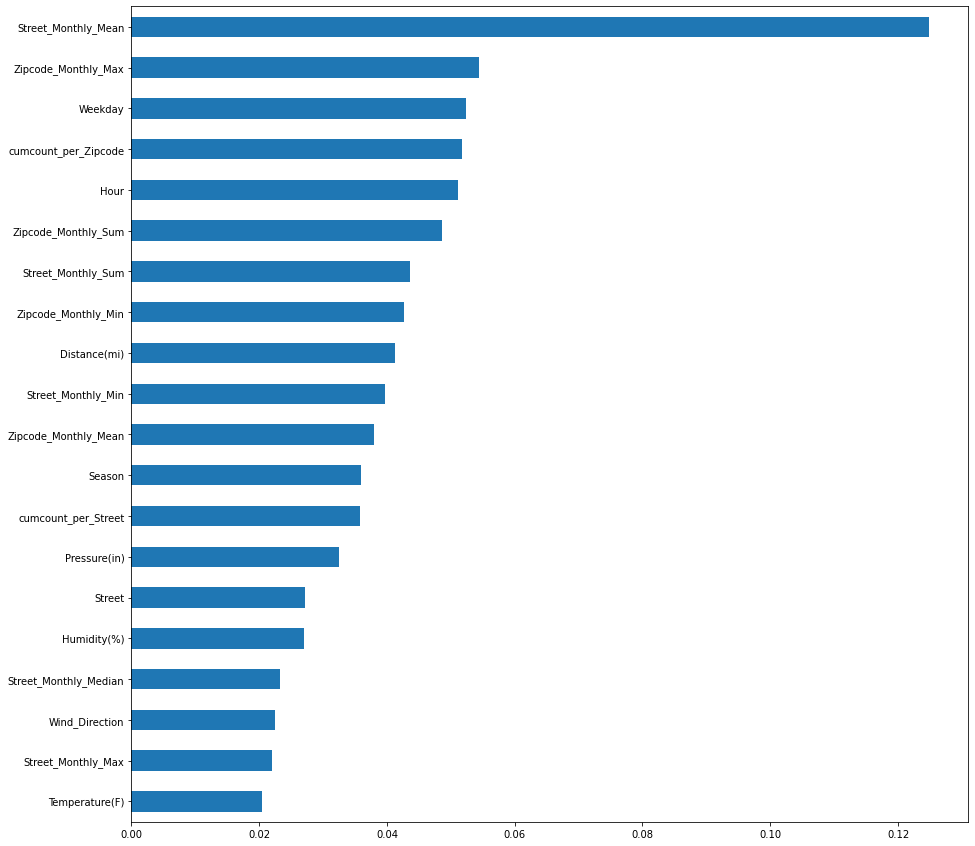

In [87]:
#feature importance of the original model
best_model_name = type(best_model).__name__
if best_model_name != 'LogisticRegression':
    extract_importances(best_model.feature_importances_,cols) 

In [88]:
#comparing models between using KMeans and without it
status = 'the same'
for i in range(n_clusters_kmeans):
    curr_model_name = type(best_models_kmeans[i]).__name__
    print(f'The model with the best performance for cluster {i} is {curr_model_name}\n')
    if curr_model_name != best_model_name:
        status = 'different'

The model with the best performance for cluster 0 is RandomForestClassifier

The model with the best performance for cluster 1 is RandomForestClassifier



In [89]:
    
print(f'We have established that using KMeans algorithm to divide the dataset would result in using {status} models for this dataset\n')
print('-----------------------------------------------------------\n')
print(f'Before using KMeans, our models yielded a change of ~ {round(original_improvement,rounding_decimals)} in {score_name} rate\n')
print(f'After using KMeans, our models yielded a change of ~ {sum(kmeans_improvement) / len(kmeans_improvement)} in {score_name} rate')

We have established that using KMeans algorithm to divide the dataset would result in using the same models for this dataset

-----------------------------------------------------------

Before using KMeans, our models yielded a change of ~ 0.17127 in accuracy rate

After using KMeans, our models yielded a change of ~ 0.0034000000000000002 in accuracy rate
